In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import scipy

sys.path.insert(0, '/home/aew492/research-summer2020/code')
from suave import cf_model
from fourparam_fit import xi_bestfit, fit_to_cf_model

### specify info

In [2]:
data_dir = '/scratch/aew492/research-summer2020_output/'

In [3]:
cat_tag = 'L750_n1e-4_z057_patchy_As2x'

In [4]:
# other parameters
rmin = 20.0
rmax = 140.0
ncont = 1000

In [5]:
rfine = np.linspace(rmin, rmax, ncont+1)

### covariance matrix

In [6]:
nmocks = 401
nbins = 22
xi_lss = np.empty((nmocks, nbins))
for rlz in range(nmocks): 
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = ls_results[0]
    xi_lss[rlz] = ls_results[1]
cov = np.cov(xi_lss.T)
print(cov.shape)

(22, 22)


## fits for a single realization

In [7]:
rlz = 1

### binned results

In [8]:
# binned results
ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
r_avg = ls_results[0]
xi_ls = ls_results[1]

### our own least squares fit results

In [9]:
# 4-parameter fit results, with full covariance matrix
fit_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/full/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
B_sq = fit_results['B_sq']
a1 = fit_results['a1']
a2 = fit_results['a2']
a3 = fit_results['a3']
bestfit_alpha = fit_results['best_alpha']
bestfit_alpha, B_sq, a1, a2, a3

(1.05,
 2.149079913203091,
 -53.17321067483433,
 1.8573151826924001,
 -0.013597886863263992)

In [10]:
xi_mod = cf_model(bestfit_alpha*rfine, cosmo_base=None, redshift=0.57, bias=2.0)
xi_fit = xi_bestfit(rfine, xi_mod, B_sq, a1, a2, a3)

### bao iterative results

In [11]:
bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
rcont, bao_basis, _, _, extra_dict = bao_results
bao_alpha = extra_dict['alpha_model']

### covariance matrix

In [12]:
nmocks = 401
nbins = len(r_avg)
xi_lss = np.empty((nmocks, nbins))
for rlz in range(nmocks): 
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = ls_results[0]
    xi_lss[rlz] = ls_results[1]
cov = np.cov(xi_lss.T)
print(cov.shape)

(22, 22)


### scipy.optimize.curve_fit

In [13]:
# scipy.optimize.curve_fit(func, xdata, ydata, x0, sigma)
# the function we want to fit to is xi_bestfit (imported from fourparam_fit.py); but to fit the right form for the fit,
#    we need to define xi_mod separately instead of calling it as a parameter

def get_xi_mod(alpha, r, cosmo_base=None, redshift=0.57, bias=2.0):
    xi_mod = cf_model(alpha*r, cosmo_base=None, redshift=0.57, bias=2.0)
    return xi_mod

xi_mod = get_xi_mod(bestfit_alpha, r_avg)

def func(r, B_sq, a1, a2, a3):
    xi_bestfit = B_sq*xi_mod + a1/r**2 + a2/r + a3
    return xi_bestfit

def B_func(r, B, a1, a2, a3):
    xi_bestfit = (B**2)*xi_mod + a1/r**2 + a2/r + a3
    return xi_bestfit

# 'best guess'; our lstsq fit results for now
p0 = np.array([B_sq, a1, a2, a3])

scipy_params, _ = scipy.optimize.curve_fit(func, r_avg, xi_ls, p0=p0, sigma=cov)

In [14]:
scipy_params

array([ 2.14907991e+00, -5.31732107e+01,  1.85731518e+00, -1.35978869e-02])

In [15]:
B_sq_s, a1_s, a2_s, a3_s = scipy_params

xi_mod = get_xi_mod(bestfit_alpha, rfine)
scipy_fit = func(rfine, B_sq_s, a1_s, a2_s, a3_s)

## compare fits

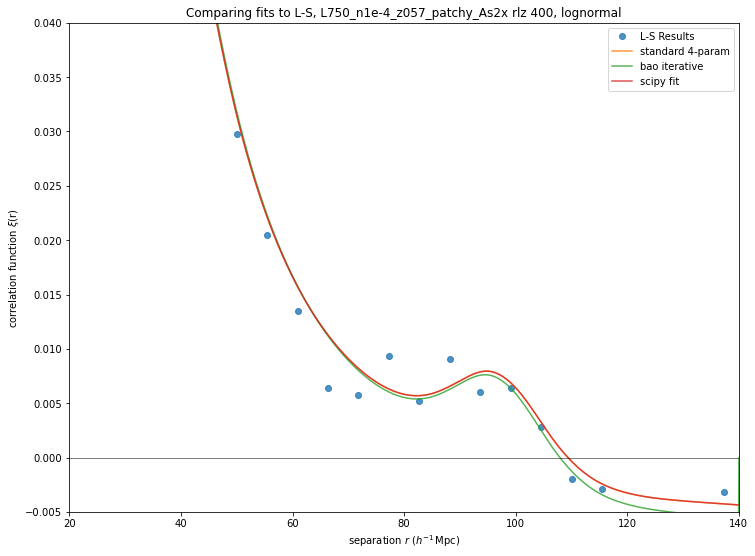

In [16]:
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, xi_ls, marker='o', ls='None', alpha=0.8, label=f'L-S Results')
plt.plot(rfine, xi_fit, lw=1.5, alpha=0.8, label=f'standard 4-param')
plt.plot(rcont, bao_basis, lw=1.5, alpha=0.8, label='bao iterative')
plt.plot(rfine, scipy_fit, alpha=0.8, label='scipy fit')

ax.set_xlim(20, 140)
ax.set_ylim(-.005, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Comparing fits to L-S, {cat_tag} rlz {rlz}, lognormal')
plt.legend()

In [17]:
xi_fit - scipy_fit

array([0., 0., 0., ..., 0., 0., 0.])

I think we understand what's going on here! The scipy fit results match our own fit exactly.

## fits for all mocks

In [43]:
# let's define a function to calculate the fits we did above:
def compare_fits(rlz, cat_tag, B_squared=False, cov=cov, rfine=rfine):
    # binned results
    ls_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    r_avg = ls_results[0]
    xi_ls = ls_results[1]
    
    # 4-parameter fit results, with full covariance matrix
    fit_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/full/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    B_sq = fit_results['B_sq']
    a1 = fit_results['a1']
    a2 = fit_results['a2']
    a3 = fit_results['a3']
    bestfit_alpha = fit_results['best_alpha']
    
    if B_sq < 0:
        print(f'rlz {rlz}')
    
    xi_mod = get_xi_mod(bestfit_alpha, rfine)
    xi_fit = xi_bestfit(rfine, xi_mod, B_sq, a1, a2, a3)
    
    # bao iterative results
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True)
    rcont, bao_basis, _, _, extra_dict = bao_results
    bao_alpha = extra_dict['alpha_model']
    
    # scipy fit
    # redefine our function for scipy
    def func(r, B_sq, a1, a2, a3):
        xi_mod = get_xi_mod(bestfit_alpha, r)
        xi_bestfit = B_sq*xi_mod + a1/r**2 + a2/r + a3
        return xi_bestfit
    def B_func(r, B, a1, a2, a3):
        xi_mod = get_xi_mod(bestfit_alpha, r)
        xi_bestfit = B**2*xi_mod + a1/r**2 + a2/r + a3
        return xi_bestfit
    
    # 'best guess'; our lstsq fit results for now
    if B_squared:
        p0 = np.array([B_sq, a1, a2, a3])
        xi_mod = get_xi_mod(bestfit_alpha, r_avg)
        scipy_params, _ = scipy.optimize.curve_fit(func, r_avg, xi_ls, p0=p0, sigma=cov)
        B_sq_s, a1_s, a2_s, a3_s = scipy_params
        scipy_fit = func(rfine, B_sq_s, a1_s, a2_s, a3_s)
    else:
        B = np.sqrt(abs(B_sq))
        p0 = np.array([B, a1, a2, a3])
        xi_mod = get_xi_mod(bestfit_alpha, r_avg)
        scipy_params, _ = scipy.optimize.curve_fit(B_func, r_avg, xi_ls, p0=p0, sigma=cov)
        B_s, a1_s, a2_s, a3_s = scipy_params
        scipy_fit = B_func(rfine, B_s, a1_s, a2_s, a3_s)
    
    # print(scipy_fit - xi_fit)
    
    results = {
        'r_avg' : r_avg,
        'xi_ls' : xi_ls,
        'rfine' : rfine,
        'xi_fit' : xi_fit,
        'scipy_fit' : scipy_fit,
        'rcont' : rcont,
        'bao_fit' : bao_basis,
        'fit_alpha' : bestfit_alpha,
        'bao_alpha' : bao_alpha,
        'B_sq' : B_sq,
        'a1' : a1,
        'a2' : a2,
        'a3' : a3,
        'B_sq_s' : B_sq_s if B_squared else B_s**2,
        'a1_s' : a1_s,
        'a2_s' : a2_s,
        'a3_s' : a3_s
    }
    return results

In [44]:
nmocks = 401
results_true = []
results_false = []
for rlz in range(nmocks):
    fit_results_true = compare_fits(rlz, cat_tag, B_squared=True)
    fit_results_false = compare_fits(rlz, cat_tag, B_squared=False)
    results_true.append(fit_results_true)
    results_false.append(fit_results_false)

rlz 3
rlz 3
rlz 5
rlz 5
rlz 15
rlz 15
rlz 34
rlz 34
rlz 43
rlz 43
rlz 44
rlz 44
rlz 76
rlz 76
rlz 84
rlz 84
rlz 93
rlz 93
rlz 97
rlz 97
rlz 119
rlz 119
rlz 130
rlz 130
rlz 131
rlz 131
rlz 142
rlz 142
rlz 143
rlz 143
rlz 146
rlz 146
rlz 155
rlz 155
rlz 163
rlz 163
rlz 176
rlz 176
rlz 223
rlz 223
rlz 234
rlz 234
rlz 276
rlz 276
rlz 306
rlz 306
rlz 327
rlz 327
rlz 333
rlz 333
rlz 342
rlz 342
rlz 350
rlz 350
rlz 362
rlz 362
rlz 363
rlz 363
rlz 369
rlz 369
rlz 378
rlz 378
rlz 381
rlz 381
rlz 391
rlz 391
rlz 392
rlz 392
rlz 395
rlz 395


In [45]:
B_sqs = np.ones(nmocks)
a1s = np.ones(nmocks)
a2s = np.ones(nmocks)
a3s = np.ones(nmocks)

B_sqs_st = np.ones(nmocks)
a1s_st = np.ones(nmocks)
a2s_st = np.ones(nmocks)
a3s_st = np.ones(nmocks)

B_sqs_sf = np.ones(nmocks)
a1s_sf = np.ones(nmocks)
a2s_sf = np.ones(nmocks)
a3s_sf = np.ones(nmocks)

for rlz in range(nmocks):
    B_sqs[rlz], a1s[rlz], a2s[rlz], a3s[rlz] = results_true[rlz]['B_sq'], results_true[rlz]['a1'], results_true[rlz]['a2'], results_true[rlz]['a3']
    B_sqs_st[rlz], a1s_st[rlz], a2s_st[rlz], a3s_st[rlz] = results_true[rlz]['B_sq_s'], results_true[rlz]['a1_s'], results_true[rlz]['a2_s'], results_true[rlz]['a3_s']
    B_sqs_sf[rlz], a1s_sf[rlz], a2s_sf[rlz], a3s_sf[rlz] = results_false[rlz]['B_sq_s'], results_false[rlz]['a1_s'], results_false[rlz]['a2_s'], results_false[rlz]['a3_s']

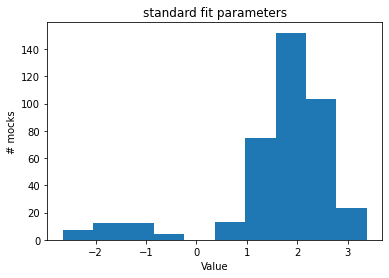

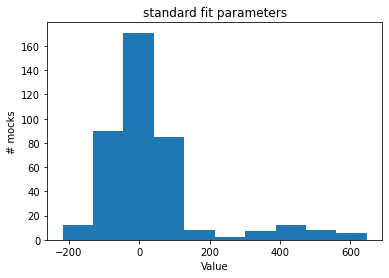

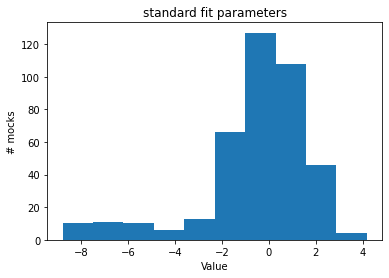

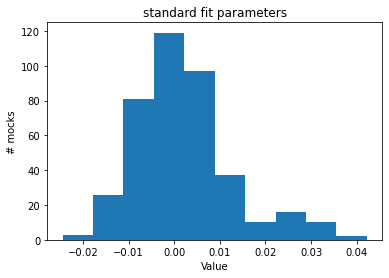

In [46]:
for params in [B_sqs, a1s, a2s, a3s]:
    plt.figure()
    plt.hist(params)
    plt.xlabel('Value')
    plt.ylabel('# mocks')
    plt.title('standard fit parameters')

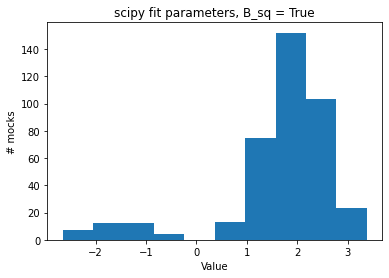

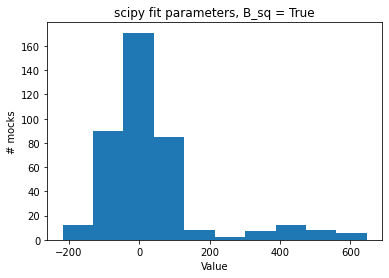

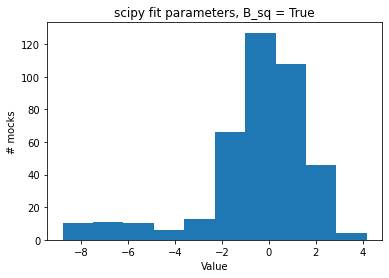

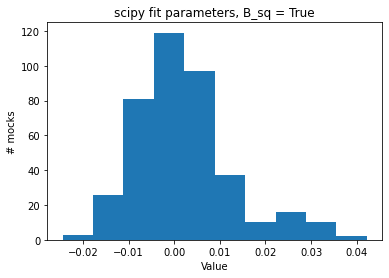

In [47]:
for params in [B_sqs_st, a1s_st, a2s_st, a3s_st]:
    plt.figure()
    plt.hist(params)
    plt.xlabel('Value')
    plt.ylabel('# mocks')
    plt.title('scipy fit parameters, B_sq = True')

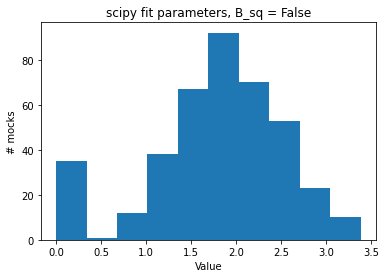

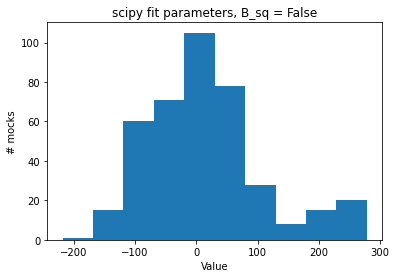

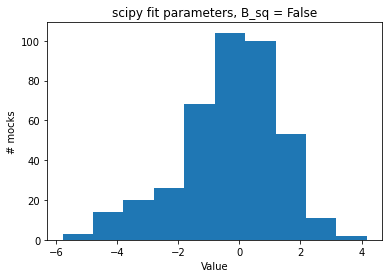

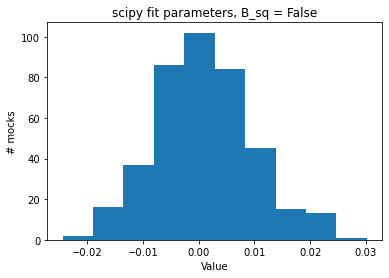

In [48]:
for params in [B_sqs_sf, a1s_sf, a2s_sf, a3s_sf]:
    plt.figure()
    plt.hist(params)
    plt.xlabel('Value')
    plt.ylabel('# mocks')
    plt.title('scipy fit parameters, B_sq = False')

In [49]:
# let's look at our results with the new constraint that B_sq >= 0
def plot_alpha_dist(results_info, nmocks, data_dir=data_dir, nbins=nbins, alpha=.6, c1=None, c2=None):
    
    rlzs = range(nmocks)
    standard_alphas = np.ones(nmocks)
    bao_alphas = np.ones(nmocks)
    for rlz in rlzs:
        standard_alphas[rlz] = results_info[rlz]['fit_alpha']        
        bao_alphas[rlz] = results_info[rlz]['bao_alpha']
    
    _, bins, _ = plt.hist(standard_alphas, bins=nbins, alpha=alpha, color=c1, label='4-param fit')
    plt.hist(bao_alphas, bins=bins, alpha=alpha, color=c2, label='bao_iterative')
    plt.xlabel('alpha')
    plt.ylabel('# rlzs')
    
    # title = f'{mock_tag}, {cat_tag}' if mock_tag == 'lognormal' else f'{mock_tag}, {cat_tag}, m={m}, b={b}'
    # plt.title(f'Distribution of alphas, 401 realizations: {title}')
    plt.legend()
    
    return standard_alphas, bao_alphas
    

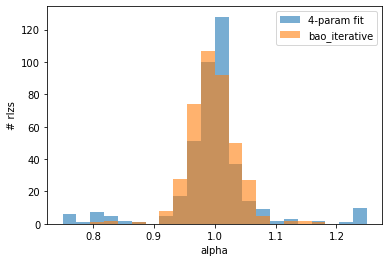

In [50]:
_, _ = plot_alpha_dist(results_false, 401)

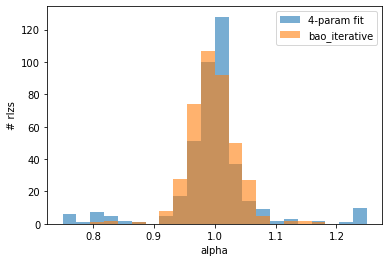

In [51]:
_, _ = plot_alpha_dist(results_true, 401)

In [52]:
rlz = 4
results_false[rlz]['xi_fit'] - results_true[rlz]['xi_fit']

array([0., 0., 0., ..., 0., 0., 0.])

## looking at script results

In [53]:
scipy_results = []
scipy_alphas = np.ones(nmocks)
bao_alphas = np.ones(nmocks)
for rlz in range(nmocks):
    scipy_basis = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/scipy/results_lognormal_{cat_tag}/basis_lognormal_{cat_tag}_rlz{rlz}_lognormal.npy'), allow_pickle=True).item()
    scipy_results.append(scipy_basis)
    scipy_alphas[rlz] = scipy_basis['best_alpha']
    
    bao_alphas[rlz] = results_false[rlz]['bao_alpha']

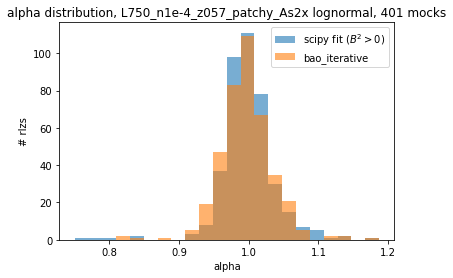

In [54]:
alpha = 0.6
_, bins, _ = plt.hist(scipy_alphas, bins=nbins, alpha=alpha, label=f'scipy fit ($B^2 > 0$)')
plt.hist(bao_alphas, bins=bins, alpha=alpha, label='bao_iterative')
plt.xlabel('alpha')
plt.ylabel('# rlzs')
plt.title(f'alpha distribution, {cat_tag} lognormal, 401 mocks')
plt.legend()

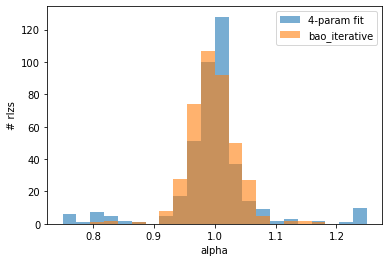

In [55]:
_, _ = plot_alpha_dist(results_false, 401)

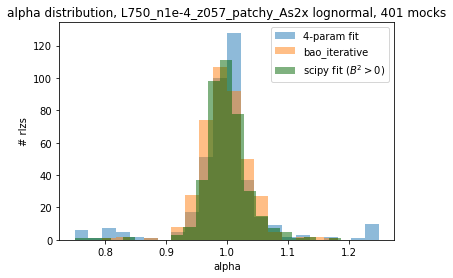

In [56]:
_, _ = plot_alpha_dist(results_false, 401, alpha=0.5)
plt.hist(scipy_alphas, bins=nbins, alpha=0.5, color='darkgreen', label=f'scipy fit ($B^2 > 0$)')
plt.title(f'alpha distribution, {cat_tag} lognormal, 401 mocks')
plt.legend()

## individual fits

In [58]:
for rlz in range(50):
    results = compare_fits(rlz, cat_tag)

rlz 3
rlz 5
rlz 15
rlz 34


/ext3/miniconda3/envs/suaveenv/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


rlz 43
rlz 44


rlz 3
rlz 5
rlz 15
rlz 34
rlz 43
rlz 44


/ext3/miniconda3/envs/suaveenv/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/ext3/miniconda3/envs/suaveenv/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/ext3/miniconda3/envs/suaveenv/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/ext3/miniconda3/envs/suaveenv/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/ext3/miniconda3/envs/suaveenv/lib/python3.9/site-packages/scipy/optimize/minpac

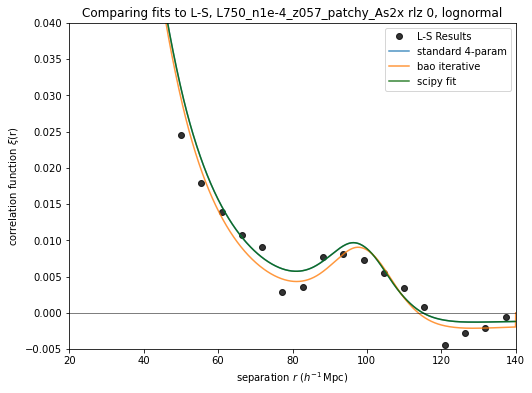

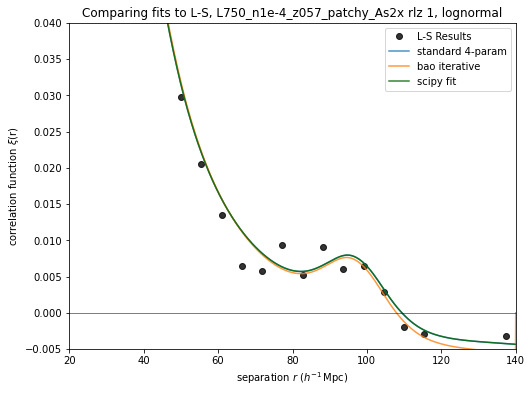

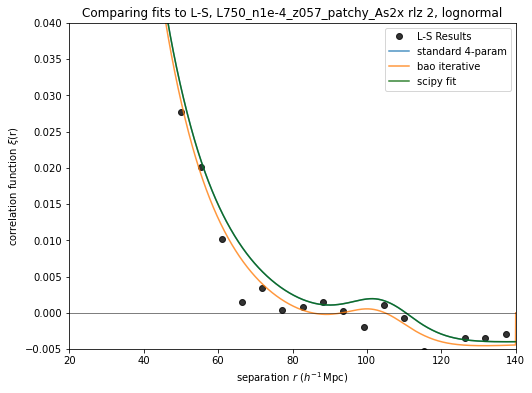

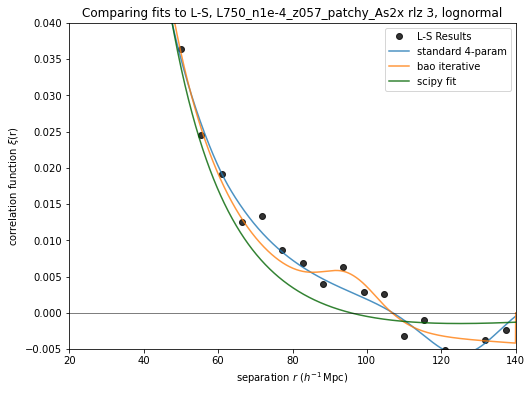

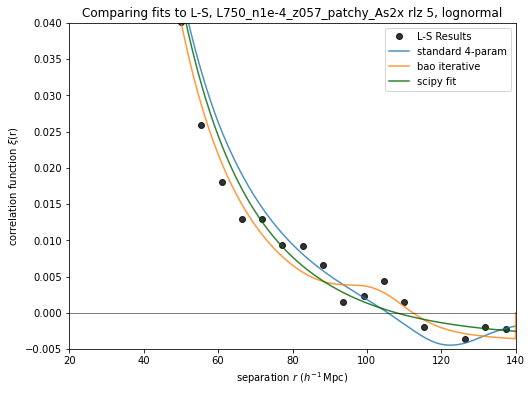

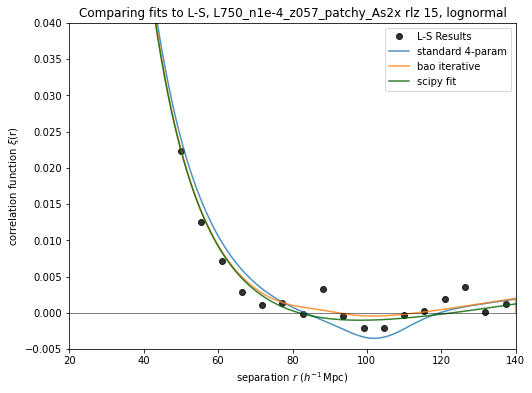

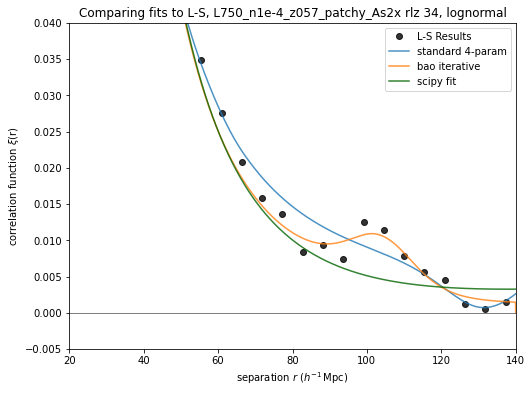

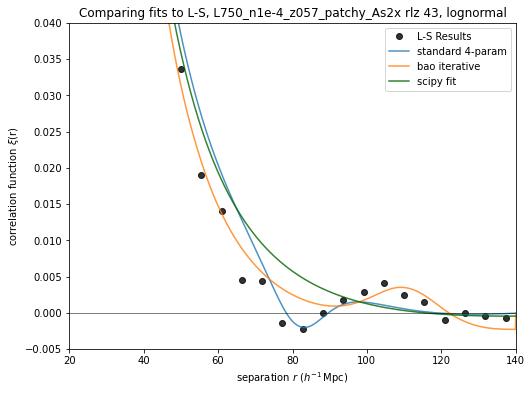

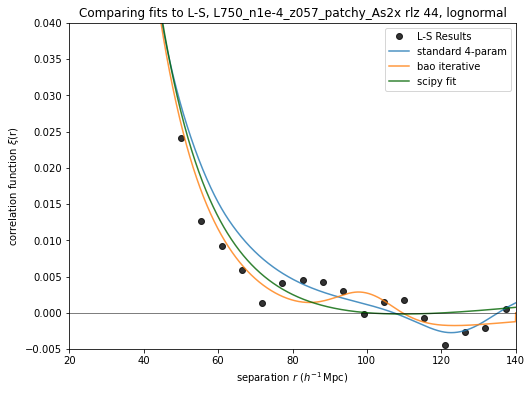

In [60]:
for rlz in [0, 1, 2, 3, 5, 15, 34, 43, 44]:
    results = compare_fits(rlz, cat_tag)
    
    # binned
    r_avg = results['r_avg']
    xi_ls = results['xi_ls']
    
    # standard
    rfine = results['rfine']
    fourparam_fit = results['xi_fit']
    
    # scipy
    scipy_fit = results['scipy_fit']
    
    # bao iterative
    rcont = results['rcont']
    bao_fit = results['bao_fit']
    
    fig, ax = plt.subplots(figsize=(8,6))

    alpha = 0.8
    plt.plot(r_avg, xi_ls, marker='o', ls='None', alpha=alpha, color='k', label=f'L-S Results')
    plt.plot(rfine, fourparam_fit, lw=1.5, alpha=alpha, color='tab:blue', label=f'standard 4-param')
    plt.plot(rcont, bao_fit, lw=1.5, alpha=alpha, color='tab:orange', label='bao iterative')
    plt.plot(rfine, scipy_fit, alpha=alpha, color='darkgreen', label='scipy fit')

    ax.set_xlim(20, 140)
    ax.set_ylim(-.005, 0.04)
    plt.axhline(0, color="k", alpha=0.5, lw=1)
    ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set_ylabel(r'correlation function $\xi$(r)')
    ax.set_title(f'Comparing fits to L-S, {cat_tag} rlz {rlz}, lognormal')
    plt.legend()